In [6]:
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap

__Set Parameters for Simulated Data Generation:__

The cell immediately below will set parameters to be used when generating the stim_data and stim_responses text files to be used for downstream analysis.

In [45]:
#set parameters for stim_data
stim_interval = 100 #interstimulus interval time
dim1_min = 1 #min x value
dim1_max = 10 #max x value
dim2_min = 1 #min y value
dim2_max = 10 #max y value

#set parameters for stim_responses
num_neurons = 100 #number of simulated neurons to generate
num_frames = 4000 #number of frames/response values per neuron
max_response = 20.0 #max response that a neuron's ap can reach (set for easier visualization)
no_response_prob = 0.2 #probability of stimulus not inducing any response

__Simulated Data Generation:__

The functions in the following cells (_generate_stim_data_, _generate_ap_, and _generate_stim_responses_) will create the stim_data.txt and stim_responses.txt files that contain the simulated neural responses to stimulus occurrences. 

These two files will serve as the primary input for the rest of analysis performed in this notebook, and are saved to the directory containing this notebook.

_generate_stim_data_ will create the stim_data.txt file, containing three columns of values; the first representing the frame number where a theoretical visual stimulation would occur, inducing an action potential in the neuron(s) we are measuring. The second and third columns contain values that would represent specific characteristics of the visual stimulus being shown. For example, in an experimental context, this could represent a different stimulus shape, size, color, etc.

_generate_ap_ will produce a gaussian-like spike representing a simulated action potential after the visual stimulus is "shown", and _generate_stim_responses_ will append these respective spikes for each neuron and output the stim_responses.txt file containing these values.

In [50]:
def generate_stim_data():
    
    #make values for stim onset
    col1 = np.arange(stim_interval, num_frames, stim_interval)

    num_stimuli = len(col1)

    #create random values for dim1 and dim2
    col2 = np.random.randint(dim1_min, dim1_max+1, size=num_stimuli)  # Random integers from 1 to 10
    col3 = np.random.randint(dim2_min, dim2_max+1, size=num_stimuli)  # Random integers from 1 to 10

    #combine
    data = np.column_stack((col1, col2, col3))

    #save
    file_name = "stim_data.txt"
    np.savetxt(file_name, data, delimiter=' ', fmt='%d')
    num_stimuli = (num_frames // stim_interval) - 1

    print(f"File {file_name} has been created with {num_stimuli} stimuli")

generate_stim_data()  

File stim_data.txt has been created with 39 stimuli


In [53]:
def generate_ap(width, amplitude):
    
    ap = np.zeros(width)
    midpoint = width // 2
    
    #make Gaussian-like spike
    for i in range(width):
        ap[i] = amplitude * np.exp(-((i - midpoint) ** 2) / (2 * (width / 6) ** 2))
        
    return ap

def generate_stim_responses():
    
    #initialize matrix with zeros
    matrix = np.zeros((num_neurons, num_frames))

    #make aps and insert into matrix
    for i in range(1, num_stimuli):
        stimulus_start = i * stim_interval
        stimulus_end = stimulus_start + stim_interval

        for neuron in range(num_neurons):

            if np.random.rand() < no_response_prob:
                # No response for this stimulus
                continue

            #create random amplitude and width for each neuron
            amplitude = np.random.uniform(1, max_response) 
            width = np.random.randint(5, 50)
            ap = generate_ap(width, amplitude)

            #place ap into matrix
            ap_start = stimulus_start + np.random.randint(0, stim_interval - width)
            ap_end = ap_start + width
            matrix[neuron, ap_start:ap_end] += ap

    file_name = "stim_responses.txt"
    np.savetxt(file_name, matrix, fmt='%.2f')

    print(f"File {file_name} has been created for {num_neurons} neurons with {num_frames} responses")
    
generate_stim_responses()

File stim_responses.txt has been created for 100 neurons with 4000 responses


__Set File Locations of Simulated Data:__

After generating the simulated data above, we set the locations of the files to their respective response_data and stim_data variables to be reference throughout the rest of the analysis.

In [55]:
response_data = "./stim_responses.txt"
stim_data = "./stim_data.txt"

__Retrieve Neural Responses:__

The function below creates a dictionary (_neurons_responses_dict_) where each key is a different neuron and the values for each neuron represent the strength of response at each frame. 

If this was experimental data, these values would represent the respective neuron's response over time while it is being recorded after multiple stimulus appearances. Based on the imaging/recording method, it is likely that artifacts or very low-quality neurons would be recorded during the experiment as well. This would require an additional filtering or QC step to ensure that only high-quality neurons are being taken into analysis.

In [63]:
def get_responses(response_data):
    
    with open(response_data, 'r') as file:
        neurons_responses = file.readlines()
        
    neurons_responses_dict = {key:[] for key in range(1, (len(neurons_responses)+1))}

    #append response at each frame for each neuron
    for neuron in range(len(neurons_responses)):
        neurons_responses_dict[neuron+1] = neurons_responses[neuron].strip("\n").split(" ")
        
    for neuron, responses in neurons_responses_dict.items():
        neurons_responses_dict[neuron] = [float(response) for response in responses if response != 'nan']
    
    responses_list = list(iter(neurons_responses_dict.values()))
    
    avg_responses_dict={'N_avg':[] for value in range(num_frames)}

    #get frame averages column-wise
    for response in range(len(responses_list[0])):
        frame_list = [frame[response] for frame in responses_list] 
        avg_responses_dict['N_avg'].append(sum(frame_list)/len(frame_list)) 

    return neurons_responses_dict, avg_responses_dict
        
neurons_responses_dict, avg_responses_dict = get_responses(response_data)

__Plot Neural Traces:__

We can visualize the traces of each neuron below, where the blue line indcates the neuron's response over the course of the "experiment". Additionally, stimuli appearances are indicated by either orange or green vertical bars in the background, depending on whether dim1 or dim2 is chosen to be displayed.

In [89]:
def neural_traces(response_data, stim_data, parameter, neuron):
    
    with open(stim_data) as file:
        stimuli = file.readlines()

    stimuli_list = []
    frames_list = []

    #append list of frames where stimulus occurrence appears
    for i in zip(stimuli):
        stimuli_list.append(i[0].split(" ", 1)[0])
        frames_list.append(i[0].strip("\n").split(" "))

    stimuli_list = [eval(y) for y in stimuli_list] #convert scientific notation to decimals
    stimuli_list.sort()

    param_list = []

    #append values of parameter corresponding to stimulus shown at respective frame
    for i in frames_list:
        if parameter == 'dim1':
            param_list.append(float(i[2]))
        elif parameter == 'dim2':
            param_list.append(float(i[1]))

    if parameter == 'dim1':
        original_cmap = cm.colormaps["Oranges"]
        dim_min = dim1_min
        dim_max = dim2_max
    elif parameter == 'dim2':
        original_cmap = cm.colormaps["Greens"]
        dim_min = dim2_min
        dim_max = dim2_max

    #truncate colorbar
    new_colors = original_cmap(np.linspace(0.2, 1))
    truncated_cmap = LinearSegmentedColormap.from_list('truncated_cmap', new_colors)

    param_list = np.array(param_list) 
    norm = Normalize(dim_min, vmax=dim_max) 

    fig, ax = plt.subplots(figsize=(12, 6))
    
    if neuron == 'all':
        ax.plot(range(num_frames), avg_responses_dict.get("N_avg"), label = "Avg Neural Response")
        plt.title(f"Avg Neural Response")
    else:
        if neuron in neurons_responses_dict.keys():
            ax.plot(range(num_frames), neurons_responses_dict.get(neuron))
            plt.title(f"Neuron {neuron} Neural Response")
        else:
            print("Neuron not in dictionary. Please choose different neuron")

    for stimulus, param_val in zip(stimuli_list, param_list):
        ax.axvline(x=stimulus, color = truncated_cmap(norm(param_val)), linewidth = "0.5")

    sm = plt.cm.ScalarMappable(cmap=truncated_cmap, norm=norm)
    sm.set_array(param_list)
    cbar = plt.colorbar(sm, ax=ax, label = f'{parameter}')
    plt.xlim(0, num_frames)
    plt.ylim(0, max_response)
    plt.xlabel("Frames")
    plt.ylabel("Response Strength")
    plt.tight_layout()
    #plt.savefig(dataset + "/" + f"neural_trace_all.png")
    
    plt.show()

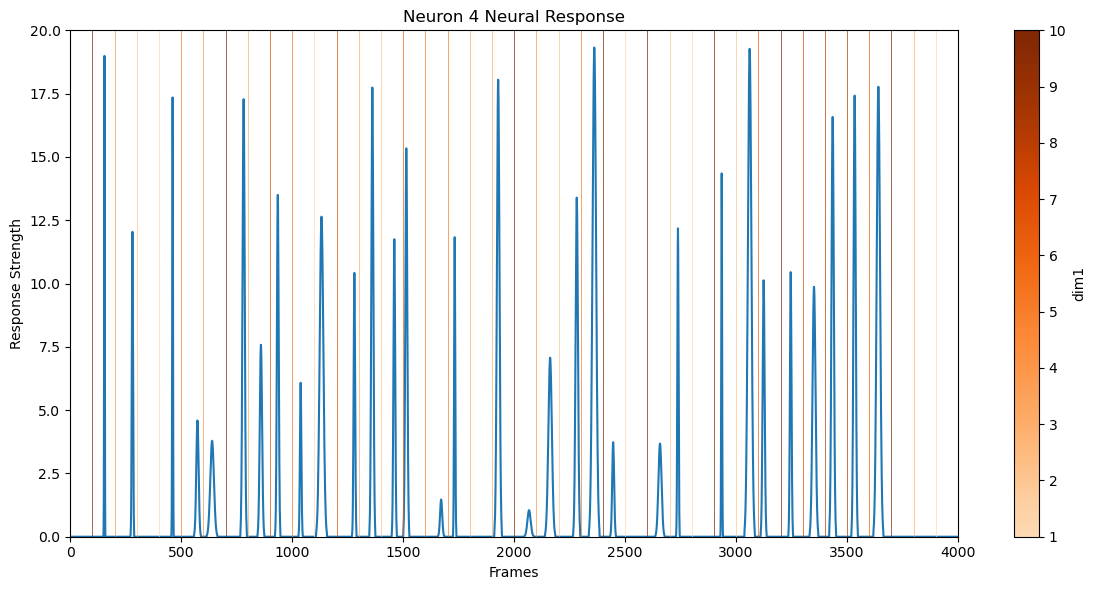

In [83]:
neural_traces(response_data, stim_data, "dim1", 4)

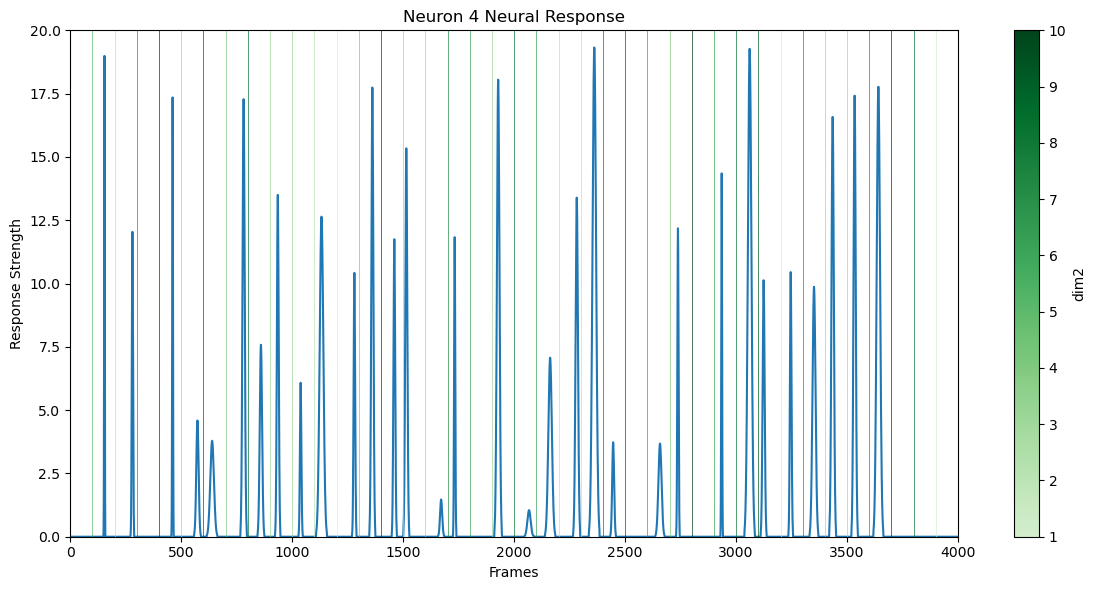

In [113]:
neural_traces(response_data, stim_data, "dim2", 4)

In an experimental context, we could plot the neural responses at each frame for all neurons in our dataset to visualize patterns or distributions in our neural population. These patterns could inform us of specific combinations of parameters, such as values of dim1 and dim2 which represent different characteristics of a visual stimuli, that are responsible for eliciting the greatest neural responses within a subpopulation.

However, since this is randomly generated data based off of a normal distribution, the average neural response below is not informative. Additionally, the simulated data generated above does not have any noise associated with it, which is obviously unlike experimental neural signals.

If we were to generate data that contained noise, we could apply a Savitzky-Golay filter to our population average to create a smoothed, fitted line to our data that would represent a "baseline". This baseline could then be used to normalize each individual neuron's signal to help reduce background noise and bring out real peaks.

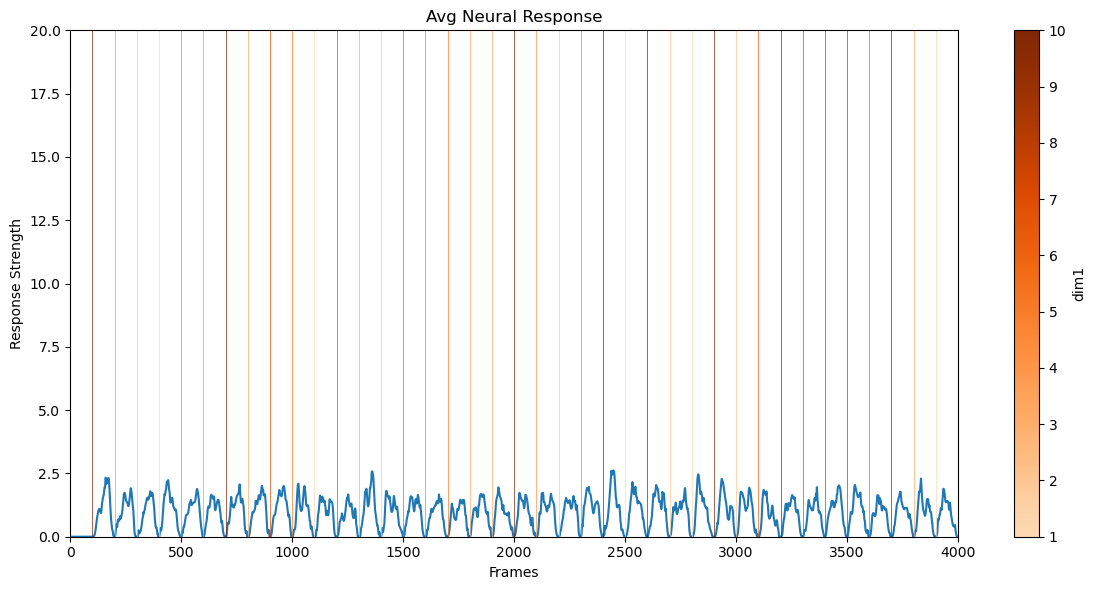

In [91]:
neural_traces(response_data, stim_data, "dim1", 'all')

__Parameter-Specific Peak Structure:__

The section below aims to extract information regarding how specific values of dim1 and dim2 (our theoretical visual stimulus) elicits changes in neural response amplitude, shape, and location.